In [55]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

In [56]:
!git clone https://github.com/hastagAB/Healthcare-Fraud-Analysis.git

fatal: destination path 'Healthcare-Fraud-Analysis' already exists and is not an empty directory.


In [57]:
# Load Dataset
Train = pd.read_csv("Healthcare-Fraud-Analysis/dataset/Train.csv")
Train_Beneficiary = pd.read_csv("Healthcare-Fraud-Analysis/dataset/Train_Beneficiary_Data.csv")
Train_Inpatient = pd.read_csv("Healthcare-Fraud-Analysis/dataset/Train_Inpatient_Data.csv")
Train_Outpatient = pd.read_csv("Healthcare-Fraud-Analysis/dataset/Train_Outpatient_Data.csv")

# Adding age column

In [58]:
Train_Beneficiary['DOB'] = pd.to_datetime(Train_Beneficiary['DOB'] , format = '%Y-%m-%d')
Train_Beneficiary['DOD'] = pd.to_datetime(Train_Beneficiary['DOD'],format = '%Y-%m-%d',errors='ignore')
Train_Beneficiary['Age'] = round(((Train_Beneficiary['DOD'] - Train_Beneficiary['DOB']).dt.days)/365)
Train_Beneficiary.Age.fillna(round(((pd.to_datetime('2009-12-01' , format = '%Y-%m-%d') - Train_Beneficiary['DOB']).dt.days)/365),inplace=True)

# Creating Master Dataframe

In [59]:
Train_Inpatient['EncounterType'] = 0
Train_Outpatient['EncounterType'] = 1
frames = [Train_Inpatient, Train_Outpatient]
TrainInAndOut = pd.concat(frames)
TrainInAndOutBenf = pd.merge(TrainInAndOut, Train_Beneficiary, how='inner', on='BeneID')
Master_df = pd.merge(TrainInAndOutBenf, Train, how='inner', on='Provider')

In [60]:
Master_df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,EncounterType,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,PotentialFraud
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1943-01-01,NaT,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,67.0,Yes
1,BENE16973,CLM565430,2009-09-06,2009-09-06,PRV55912,50,PHY365867,PHY327147,NaN,NaN,NaN,0.0,NaN,NaN,V7183,53081,78959,4280,E8788,78079,79902,25002,71848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1932-05-01,NaT,1,1,0,39,310,12,12,1,1,1,2,2,2,2,1,2,2,2,24000,2136,450,200,78.0,Yes
2,BENE17521,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,2009-01-20,45340,1068.0,2009-02-01,987,4240,2639,2948,40390,45821,28489,5854,2753,E9305,NaN,7769.0,5849.0,NaN,NaN,NaN,NaN,0,1913-12-01,NaT,2,1,0,39,230,12,12,1,1,1,2,1,2,2,1,2,2,2,19000,1068,100,20,96.0,Yes
3,BENE21718,CLM72336,2009-10-17,2009-11-04,PRV55912,17000,PHY334706,PHY334706,NaN,2009-10-17,V5789,1068.0,2009-11-04,941,V5789,4168,73313,7812,7993,78830,72273,43812,4019,NaN,9338.0,NaN,NaN,NaN,NaN,NaN,0,1922-10-01,NaT,1,1,0,39,600,12,12,2,2,2,2,2,2,2,1,1,2,2,17000,1068,1050,540,87.0,Yes
4,BENE22934,CLM73394,2009-10-25,2009-10-29,PRV55912,13000,PHY390614,PHY323689,PHY363291,2009-10-25,71946,1068.0,2009-10-29,506,71535,71960,4019,V1202,4240,2449,2768,NaN,NaN,NaN,8154.0,NaN,NaN,NaN,NaN,NaN,0,1930-07-01,NaT,2,1,0,39,280,12,12,2,1,2,2,1,2,1,1,1,1,2,27000,2136,450,160,79.0,Yes


# Remove DOD with IsDead and droping DOB as we have age

In [61]:
Master_df.loc[Master_df['DOD'].isnull(), 'IsDead'] = '0'
Master_df.loc[(Master_df['DOD'].notnull()), 'IsDead'] = '1'
Master_df = Master_df.drop(['DOD'], axis = 1)
Master_df = Master_df.drop(['DOB'], axis = 1)

In [62]:
Master_df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,EncounterType,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,PotentialFraud,IsDead
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,67.0,Yes,0
1,BENE16973,CLM565430,2009-09-06,2009-09-06,PRV55912,50,PHY365867,PHY327147,NaN,NaN,NaN,0.0,NaN,NaN,V7183,53081,78959,4280,E8788,78079,79902,25002,71848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,0,39,310,12,12,1,1,1,2,2,2,2,1,2,2,2,24000,2136,450,200,78.0,Yes,0
2,BENE17521,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,2009-01-20,45340,1068.0,2009-02-01,987,4240,2639,2948,40390,45821,28489,5854,2753,E9305,NaN,7769.0,5849.0,NaN,NaN,NaN,NaN,0,2,1,0,39,230,12,12,1,1,1,2,1,2,2,1,2,2,2,19000,1068,100,20,96.0,Yes,0
3,BENE21718,CLM72336,2009-10-17,2009-11-04,PRV55912,17000,PHY334706,PHY334706,NaN,2009-10-17,V5789,1068.0,2009-11-04,941,V5789,4168,73313,7812,7993,78830,72273,43812,4019,NaN,9338.0,NaN,NaN,NaN,NaN,NaN,0,1,1,0,39,600,12,12,2,2,2,2,2,2,2,1,1,2,2,17000,1068,1050,540,87.0,Yes,0
4,BENE22934,CLM73394,2009-10-25,2009-10-29,PRV55912,13000,PHY390614,PHY323689,PHY363291,2009-10-25,71946,1068.0,2009-10-29,506,71535,71960,4019,V1202,4240,2449,2768,NaN,NaN,NaN,8154.0,NaN,NaN,NaN,NaN,NaN,0,2,1,0,39,280,12,12,2,1,2,2,1,2,1,1,1,1,2,27000,2136,450,160,79.0,Yes,0


# Calculating the number of days the patient was admitted

In [63]:
Master_df['AdmissionDt'] = pd.to_datetime(Master_df['AdmissionDt'] , format = '%Y-%m-%d')
Master_df['DischargeDt'] = pd.to_datetime(Master_df['DischargeDt'],format = '%Y-%m-%d')
Master_df['DaysAdmitted'] = ((Master_df['DischargeDt'] - Master_df['AdmissionDt']).dt.days)+1
Master_df.loc[Master_df['EncounterType'] == 1, 'DaysAdmitted'] = '0'
Master_df[['EncounterType','DaysAdmitted','DischargeDt','AdmissionDt']].head()
Master_df = Master_df.drop(['DischargeDt'], axis = 1)
Master_df = Master_df.drop(['AdmissionDt'], axis = 1)
Master_df.loc[Master_df['DeductibleAmtPaid'].isnull(), 'DeductibleAmtPaid'] = '0'

In [64]:
cols= ['ClmAdmitDiagnosisCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_10',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6']

Master_df[cols]= Master_df[cols].replace({np.nan:0})

In [65]:
Master_df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,EncounterType,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,PotentialFraud,IsDead,DaysAdmitted
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,7866,1068,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,67.0,Yes,0,7
1,BENE16973,CLM565430,2009-09-06,2009-09-06,PRV55912,50,PHY365867,PHY327147,NaN,0,0,NaN,V7183,53081,78959,4280,E8788,78079,79902,25002,71848,0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,0,39,310,12,12,1,1,1,2,2,2,2,1,2,2,2,24000,2136,450,200,78.0,Yes,0,0
2,BENE17521,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,45340,1068,987,4240,2639,2948,40390,45821,28489,5854,2753,E9305,0,7769.0,5849.0,0.0,0.0,0.0,0.0,0,2,1,0,39,230,12,12,1,1,1,2,1,2,2,1,2,2,2,19000,1068,100,20,96.0,Yes,0,13
3,BENE21718,CLM72336,2009-10-17,2009-11-04,PRV55912,17000,PHY334706,PHY334706,NaN,V5789,1068,941,V5789,4168,73313,7812,7993,78830,72273,43812,4019,0,9338.0,0.0,0.0,0.0,0.0,0.0,0,1,1,0,39,600,12,12,2,2,2,2,2,2,2,1,1,2,2,17000,1068,1050,540,87.0,Yes,0,19
4,BENE22934,CLM73394,2009-10-25,2009-10-29,PRV55912,13000,PHY390614,PHY323689,PHY363291,71946,1068,506,71535,71960,4019,V1202,4240,2449,2768,0,0,0,8154.0,0.0,0.0,0.0,0.0,0.0,0,2,1,0,39,280,12,12,2,1,2,2,1,2,1,1,1,1,2,27000,2136,450,160,79.0,Yes,0,5


In [66]:
for i in cols:
    Master_df[i][Master_df[i]!=0]= 1

Master_df[cols]= Master_df[cols].astype(float)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Calculating Total Diagnosis and Total Procedure

In [67]:
Master_df['TotalDiagnosis'] = (
    Master_df['ClmDiagnosisCode_1'] + 
    Master_df['ClmDiagnosisCode_10'] + 
    Master_df['ClmDiagnosisCode_2'] + 
    Master_df['ClmDiagnosisCode_3'] + 
    Master_df['ClmDiagnosisCode_4'] + 
    Master_df['ClmDiagnosisCode_5'] + 
    Master_df['ClmDiagnosisCode_6'] + 
    Master_df['ClmDiagnosisCode_7'] + 
    Master_df['ClmDiagnosisCode_8'] + 
    Master_df['ClmDiagnosisCode_9']
)

Master_df['TotalProcedure'] = (
    Master_df['ClmProcedureCode_1'] + 
    Master_df['ClmProcedureCode_2'] + 
    Master_df['ClmProcedureCode_3'] + 
    Master_df['ClmProcedureCode_4'] + 
    Master_df['ClmProcedureCode_5'] + 
    Master_df['ClmProcedureCode_6']
)

In [68]:
remove=['Provider','BeneID', 'ClaimID', 'ClaimStartDt','ClaimEndDt','AttendingPhysician',
       'OperatingPhysician', 'OtherPhysician', 'ClmDiagnosisCode_1',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
       'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3',
       'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6',
       'ClmAdmitDiagnosisCode','DeductibleAmtPaid','NoOfMonths_PartACov',
        'NoOfMonths_PartBCov','DiagnosisGroupCode',
        'State', 'County']

Master_df.drop(columns=remove, axis=1, inplace=True)

In [69]:
Master_df.head(10)

,InscClaimAmtReimbursed,EncounterType,Gender,Race,RenalDiseaseIndicator,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,PotentialFraud,IsDead,DaysAdmitted,TotalDiagnosis,TotalProcedure
0,26000,0,1,1,0,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,67.0,Yes,0,7,9.0,0.0
1,50,1,1,1,0,1,1,1,2,2,2,2,1,2,2,2,24000,2136,450,200,78.0,Yes,0,0,9.0,0.0
2,19000,0,2,1,0,1,1,1,2,1,2,2,1,2,2,2,19000,1068,100,20,96.0,Yes,0,13,9.0,2.0
3,17000,0,1,1,0,2,2,2,2,2,2,2,1,1,2,2,17000,1068,1050,540,87.0,Yes,0,19,9.0,1.0
4,13000,0,2,1,0,2,1,2,2,1,2,1,1,1,1,2,27000,2136,450,160,79.0,Yes,0,5,7.0,1.0
5,3000,0,2,2,0,1,2,2,1,2,2,2,1,2,2,2,3000,1068,8900,740,84.0,Yes,0,5,1.0,1.0
6,20,1,1,2,0,1,1,1,1,2,2,1,1,2,2,2,17000,2136,3810,40,63.0,Yes,0,0,0.0,0.0
7,10000,0,1,1,0,2,1,2,1,1,1,1,1,2,2,2,10000,1068,550,190,76.0,Yes,0,4,10.0,1.0
8,18000,0,2,1,Y,1,1,1,2,2,2,1,1,2,1,2,18000,1068,1440,520,50.0,Yes,0,9,9.0,0.0
9,13000,0,2,2,Y,1,1,1,1,1,1,1,1,1,1,1,51320,6408,770,300,76.0,Yes,0,22,9.0,1.0


# Creating Disease Indicator as a switch

In [70]:
Master_df['RenalDiseaseIndicator'] = Master_df['RenalDiseaseIndicator'].replace({'Y':1,'0':0})
Master_df['RenalDiseaseIndicator'] = Master_df['RenalDiseaseIndicator'].astype(int)

In [71]:
Master_df.describe(include='O')

,PotentialFraud,IsDead,DaysAdmitted
count,558211,558211,558211
unique,2,2,37
top,No,0,0
freq,345415,554080,517737


Formatting the values

In [72]:
Master_df['IsDead']=Master_df['IsDead'].astype(float)
Master_df['DaysAdmitted']=Master_df['DaysAdmitted'].astype(float)
Master_df['PotentialFraud']=Master_df['PotentialFraud'].replace({'Yes':1, 'No':0})
Master_df['PotentialFraud']=Master_df['PotentialFraud'].astype(int)

In [73]:
x = Master_df.drop('PotentialFraud', axis=1)
y = Master_df.loc[:,'PotentialFraud']

In [74]:
x.columns

Index(['InscClaimAmtReimbursed', 'EncounterType', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age', 'IsDead',
       'DaysAdmitted', 'TotalDiagnosis', 'TotalProcedure'],
      dtype='object')

In [75]:
num_col= ['InscClaimAmtReimbursed',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age',
       'DaysAdmitted', 'TotalDiagnosis', 'TotalProcedure']

cat_col= ['EncounterType', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke','IsDead']

x_cat= x.loc[:,cat_col]
x_cat.head()

,EncounterType,Gender,Race,RenalDiseaseIndicator,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IsDead
0,0,1,1,0,1,2,1,2,2,1,1,1,2,1,1,0.0
1,1,1,1,0,1,1,1,2,2,2,2,1,2,2,2,0.0
2,0,2,1,0,1,1,1,2,1,2,2,1,2,2,2,0.0
3,0,1,1,0,2,2,2,2,2,2,2,1,1,2,2,0.0
4,0,2,1,0,2,1,2,2,1,2,1,1,1,1,2,0.0


In [76]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
x_num = scale.fit_transform(x[num_col])

In [77]:
x_num= pd.DataFrame(x_num, columns=[
                                    'InscClaimAmtReimbursed',
                                    'IPAnnualReimbursementAmt', 
                                    'IPAnnualDeductibleAmt',
                                    'OPAnnualReimbursementAmt', 
                                    'OPAnnualDeductibleAmt', 
                                    'Age','DaysAdmitted', 
                                    'TotalDiagnosis', 
                                    'TotalProcedure'
                                    ])

x= pd.concat([x_num, x_cat], axis=1)
x.head()

,InscClaimAmtReimbursed,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,DaysAdmitted,TotalDiagnosis,TotalProcedure,EncounterType,Gender,Race,RenalDiseaseIndicator,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IsDead
0,6.542662,2.610838,2.234826,-0.571436,-0.578530,-0.519851,2.832646,2.446318,-0.190910,0,1,1,0,1,2,1,2,2,1,1,1,2,1,1,0.0
1,-0.247810,1.592704,1.329105,-0.470968,-0.448792,0.324840,-0.210064,2.446318,-0.190910,1,1,1,0,1,1,1,2,2,2,2,1,2,2,2,0.0
2,4.710935,1.168481,0.423385,-0.561132,-0.628429,1.707062,5.440682,2.446318,6.938348,0,2,1,0,1,1,1,2,1,2,2,1,2,2,2,0.0
3,4.187585,0.998792,0.423385,-0.316403,-0.109478,1.015951,8.048719,2.446318,3.373719,0,1,1,0,2,2,2,2,2,2,2,1,1,2,2,0.0
4,3.140884,1.847237,1.329105,-0.470968,-0.488712,0.401630,1.963300,1.629395,3.373719,0,2,1,0,2,1,2,2,1,2,1,1,1,1,2,0.0


# Test Train Split

In [80]:
from sklearn.model_selection import train_test_split

x_train,x_test, y_train, y_test= train_test_split(x,y, test_size=0.1, random_state=42)

acc_score = []

# Machine Learning Models

# Decision Tree

In [81]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

estimator=  DecisionTreeClassifier()

param_grid= {
    'criterion':[
                 'gini', 'entropy'
                 ],
             'max_depth':[3,4,5],
             'min_samples_split':[2,3,5]
             }

grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid)
grid_search.fit(x_train, y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)

0.6301073464557836
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}


# Random Forest

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

estimator1= RandomForestClassifier()
estimator1.fit(x_train, y_train)
model_score= estimator1.predict(x_train)
accuracy= estimator1.predict(x_test)
acc_score.append({'Model':'Random Forest', 'Score': accuracy_score(y_train, model_score), 'Accuracy': accuracy_score(y_test, accuracy)})
print(accuracy_score(y_train, model_score))
print(accuracy_score(y_test, accuracy))

0.991204027158238
0.6981655977929848


In [83]:
confusion_matrix(y_test,accuracy)

array([[28470,  6218],
       [10680, 10454]])

# Naive Bayes

In [94]:
from sklearn.naive_bayes import GaussianNB
bayes= GaussianNB()
bayes.fit(x_train, y_train)
train_pred= bayes.predict(x_train)
test_pred= bayes.predict(x_test)
acc_score.append({'Model':'Naive Bayes', 'Score': accuracy_score(y_train, model_score), 'Accuracy': accuracy_score(y_test, accuracy)})
print(accuracy_score(y_train,train_pred))
print(accuracy_score(y_test,test_pred))

0.6233436639735345
0.6254881587904411


In [85]:
confusion_matrix(y_test,test_pred)

array([[31737,  2951],
       [17955,  3179]])

# Logistic Regression

In [95]:
from sklearn.linear_model import LogisticRegression
lr= LogisticRegression()
lr.fit(x_train, y_train)
train_pred= lr.predict(x_train)
test_pred= lr.predict(x_test)
acc_score.append({'Model': "Logistic Regression", 'Score': accuracy_score(y_train,train_pred), 'Accuracy': accuracy_score(y_test,test_pred)})
print(accuracy_score(y_train,train_pred))
print(accuracy_score(y_test,test_pred))

0.6299401459824956
0.6318297445451614


In [87]:
confusion_matrix(y_test,test_pred)

array([[32902,  1786],
       [18766,  2368]])

In [88]:
estimator=  DecisionTreeClassifier(criterion= 'gini', max_depth=5, min_samples_split= 2)
estimator.fit(x_train, y_train)
model_score= estimator.predict(x_train)
accuracy= estimator.predict(x_test)
acc_score.append({'Model':'Decision Tree', 'Score': accuracy_score(y_train, model_score), 'Accuracy': accuracy_score(y_test, accuracy)})

[Text(3394.0848214285716, 4152.5, 'EncounterType <= 0.5\ngini = 0.472\nsamples = 502389\nvalue = [310727, 191662]\nclass = No'),
 Text(1806.0267857142858, 3397.5, 'DaysAdmitted <= 9.57\ngini = 0.487\nsamples = 36320\nvalue = [15286, 21034]\nclass = Yes'),
 Text(996.4285714285714, 2642.5, 'Age <= -3.246\ngini = 0.488\nsamples = 35316\nvalue = [14938, 20378]\nclass = Yes'),
 Text(498.2142857142857, 1887.5, 'InscClaimAmtReimbursed <= 0.917\ngini = 0.498\nsamples = 256\nvalue = [137, 119]\nclass = No'),
 Text(249.10714285714286, 1132.5, 'ChronicCond_Heartfailure <= 1.5\ngini = 0.426\nsamples = 78\nvalue = [54, 24]\nclass = No'),
 Text(124.55357142857143, 377.5, 'gini = 0.352\nsamples = 57\nvalue = [44, 13]\nclass = No'),
 Text(373.6607142857143, 377.5, 'gini = 0.499\nsamples = 21\nvalue = [10, 11]\nclass = Yes'),
 Text(747.3214285714286, 1132.5, 'IPAnnualReimbursementAmt <= 3.612\ngini = 0.498\nsamples = 178\nvalue = [83, 95]\nclass = Yes'),
 Text(622.7678571428571, 377.5, 'gini = 0.5\nsam

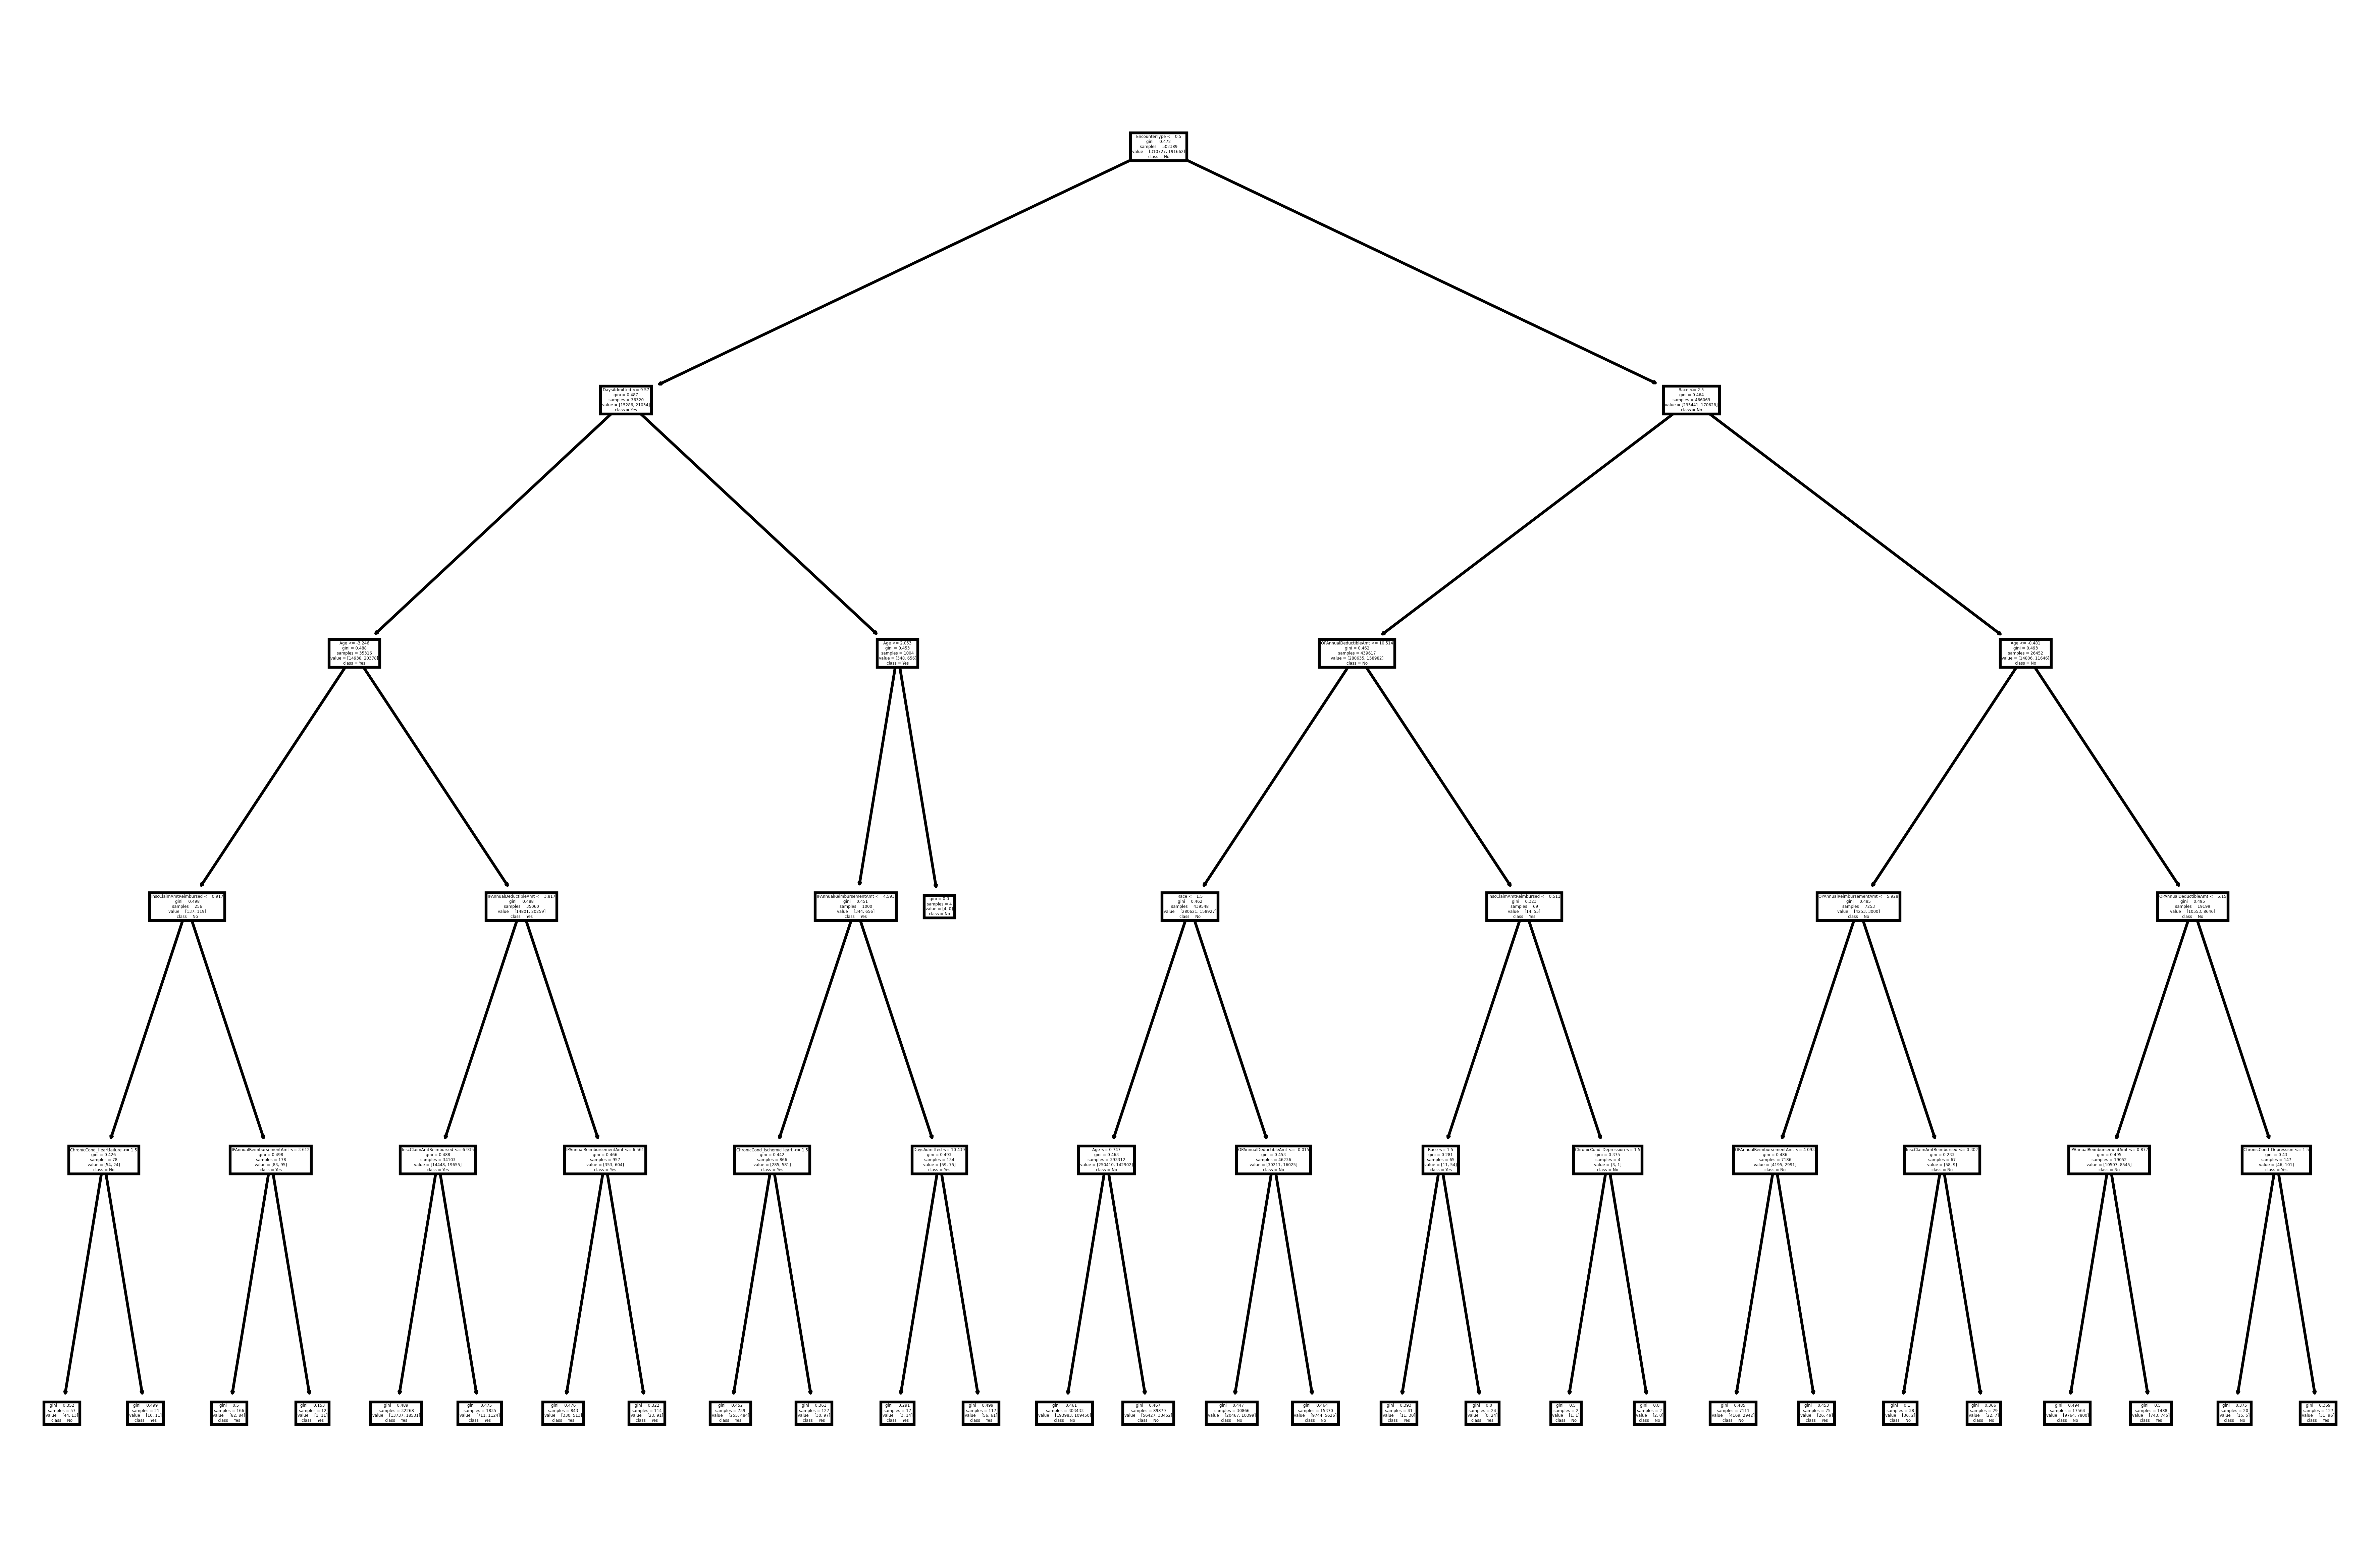

In [89]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn import tree

fn= ['InscClaimAmtReimbursed', 'IPAnnualReimbursementAmt',
    'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
    'OPAnnualDeductibleAmt', 'Age', 'DaysAdmitted',
    'TotalDiagnosis', 'TotalProcedure', 'EncounterType', 'Gender', 'Race',
    'RenalDiseaseIndicator', 'ChronicCond_Alzheimer',
    'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
    'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
    'ChronicCond_Depression', 'ChronicCond_Diabetes',
    'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
    'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke', 'IsDead']

cl=['No','Yes']

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (15,10), dpi=600)
tree.plot_tree(estimator, feature_names= fn, class_names=cl)


In [90]:
confusion_matrix(y_test,accuracy)

array([[32803,  1885],
       [18684,  2450]])

In [96]:
accuracy= pd.DataFrame(acc_score, columns=['Model','Score','Accuracy'])
accuracy.sort_values(by='Accuracy', ascending= False, inplace= True)
accuracy

,Model,Score,Accuracy
1,Random Forest,0.991204,0.698166
2,Naive Bayes,0.991204,0.698166
3,Logistic Regression,0.629940,0.631830
0,Decision Tree,0.630275,0.631525


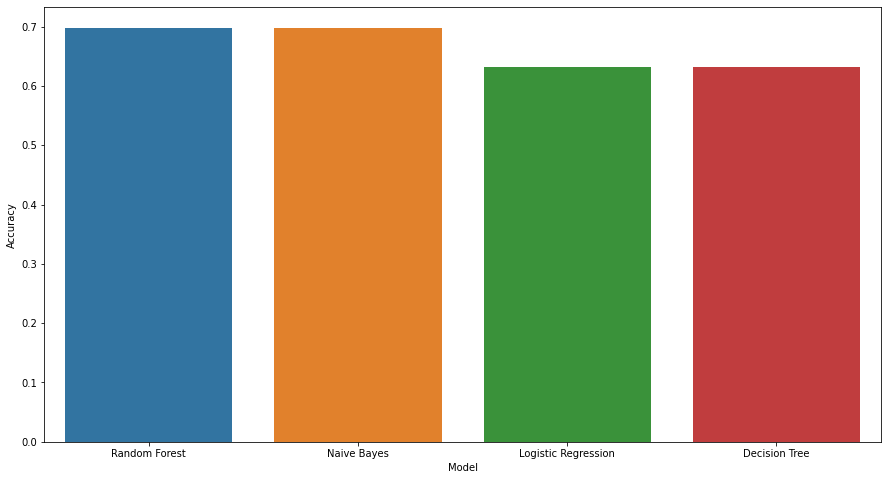

In [97]:
import seaborn as sns
plt.figure(figsize=(15,8))
sns.barplot(x= accuracy.Model, y=accuracy.Accuracy)